In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from pathlib import Path
import time

In [23]:
# Grab the directory of the current file
# Should be ./Project/src/Program
try:
    current_dir = Path(__file__).parent.absolute()
except NameError:
    # If using a Jupyter notebook
    try:
        current_dir = Path.cwd()
    except:
        # If continuing to fail set path manually
        current_dir = Path("D:/School/CS 434/Project/src/Program")

# Go to the Data directory 
# Should be ./Project/src/Data
data_dir = current_dir.parent / "Data"

# Get the Dataset paths
imputed_path = data_dir / "loan_data_imputed.csv"
removed_path = data_dir / "loan_data_removed.csv"

# Verify the file exists
if imputed_path.exists() and removed_path.exists():
    print(f"Imputed dataset found at: {imputed_path}")
    df_imputed = pd.read_csv(imputed_path)
    print(f"Removed dataset found at: {removed_path}")
    df_removed = pd.read_csv(removed_path)
else:
    print(f"One or both datasets not found at expected path: {data_dir}")

# Show basic info
print("Imputed dataset shape:", df_imputed.shape)
print("Removed dataset shape:", df_removed.shape)

Imputed dataset found at: d:\School\CS 434\Project\src\Data\loan_data_imputed.csv
Removed dataset found at: d:\School\CS 434\Project\src\Data\loan_data_removed.csv
Imputed dataset shape: (367, 14)
Removed dataset shape: (289, 14)


In [24]:
def preprocess_data(df, dataset_name):
    print(f"\n--- Preprocessing {dataset_name} dataset ---")

    # Separate features and target
    X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
    y = df['Loan_Status']

    # Feature Engineering
    # Create total income feature
    X['Total_Income'] = X['ApplicantIncome'] + X['CoapplicantIncome']

    # Create income to loan ratio
    X['Income_to_Loan_Ratio'] = X['Total_Income'] / X['LoanAmount']
    X['Income_to_Loan_Ratio'] = X['Income_to_Loan_Ratio'].replace([np.inf, -np.inf], np.nan)
    X['Income_to_Loan_Ratio'] = X['Income_to_Loan_Ratio'].fillna(X['Income_to_Loan_Ratio'].median())

    # Log transform skewed features
    X['ApplicantIncome_Log'] = np.log1p(X['ApplicantIncome'])
    X['CoapplicantIncome_Log'] = np.log1p(X['CoapplicantIncome'])  # Create this column first
    X['CoapplicantIncome_Log'] = X['CoapplicantIncome_Log'].replace([np.inf, -np.inf], np.nan)
    X['LoanAmount_Log'] = np.log1p(X['LoanAmount'])
    X['TotalIncome_Log'] = np.log1p(X['Total_Income'])

    # Handle outliers using capping
    for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

    # Feature selection
    selector = SelectKBest(f_classif, k=10)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()]
    print("Selected features:", selected_features.tolist())

    # Check for class imbalance
    if len(np.unique(y_train)) > 1:  # Make sure there are at least 2 classes
        class_counts = np.bincount(y_train.astype(int))
        if abs(class_counts[0] - class_counts[1]) / len(y_train) > 0.2:
            print("Class imbalance detected. Applying SMOTE...")
            smote = SMOTE(random_state=42)
            X_train_selected, y_train = smote.fit_resample(X_train_selected, y_train)
            print("After SMOTE - Class distribution:", np.bincount(y_train.astype(int)))

    return X_train_selected, X_test_selected, y_train, y_test, selected_features

In [25]:
# Preprocess both datasets
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed, selected_features_imputed = preprocess_data(df_imputed, "Imputed")
X_train_removed, X_test_removed, y_train_removed, y_test_removed, selected_features_removed = preprocess_data(df_removed, "Removed")


--- Preprocessing Imputed dataset ---
Selected features: ['Gender', 'Married', 'ApplicantIncome', 'LoanAmount', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Total_Income', 'ApplicantIncome_Log', 'LoanAmount_Log']
Class imbalance detected. Applying SMOTE...
After SMOTE - Class distribution: [234 234]

--- Preprocessing Removed dataset ---
Selected features: ['Gender', 'Married', 'ApplicantIncome', 'LoanAmount', 'Credit_History', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Total_Income', 'ApplicantIncome_Log', 'LoanAmount_Log']
Class imbalance detected. Applying SMOTE...
After SMOTE - Class distribution: [182 182]


In [ ]:
def train_and_tune_model(X_train, y_train, dataset_name):
    print(f"\n--- Training and Tuning Model for {dataset_name} Dataset ---")

    # Define parameter combinations that are compatible
    param_combinations = [
        # l1 penalty
        {'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga'], 
         'class_weight': [None, 'balanced'], 'max_iter': [200]},

        # l2 penalty
        {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
         'class_weight': [None, 'balanced'], 'max_iter': [200]},

        # elasticnet penalty
        {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['saga'], 
         'class_weight': [None, 'balanced'], 'max_iter': [200], 'l1_ratio': [0.5]},

        # no penalty
        {'penalty': [None], 'C': [0.001, 0.01, 0.1, 1, 10], 
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
         'class_weight': [None, 'balanced'], 'max_iter': [200]}
    ]

    # Grid search with cross-validation
    start_time = time.time()

    # Create base model
    model = LogisticRegression(random_state=42)

    # Use GridSearchCV with the correct parameter grid format
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_combinations,  # This is the correct format
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    training_time = time.time() - start_time

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

    return grid_search.best_estimator_, training_time

In [34]:
# Train and tune models for both datasets
model_imputed, time_imputed = train_and_tune_model(X_train_imputed, y_train_imputed, "Imputed")
model_removed, time_removed = train_and_tune_model(X_train_removed, y_train_removed, "Removed")


--- Training and Tuning Model for Imputed Dataset ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'C': 1, 'class_weight': None, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8847
Training time: 2.59 seconds

--- Training and Tuning Model for Removed Dataset ---
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.8726
Training time: 0.33 seconds


In [35]:
def evaluate_model(model, X_test, y_test, dataset_name, training_time, selected_features=None):
    print(f"\n--- Evaluating Model for {dataset_name} Dataset ---")

    # Prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Total execution time: {training_time + prediction_time:.2f} seconds")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Feature importance (if applicable)
    if hasattr(model, 'coef_') and selected_features is not None:
        coef = model.coef_[0]
        feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(coef)})
        feature_importance = feature_importance.sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title(f'Feature Importance - {dataset_name}')
        plt.tight_layout()
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'prediction_time': prediction_time
    }


--- Evaluating Model for Imputed Dataset ---
Accuracy: 0.9459
Precision: 0.9800
Recall: 0.9423
F1 Score: 0.9608
ROC-AUC Score: 0.9956
Prediction time: 0.0000 seconds
Total execution time: 2.59 seconds


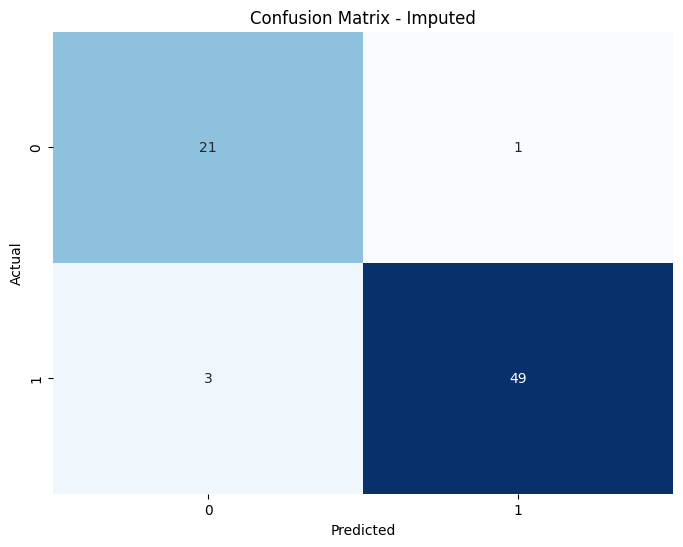

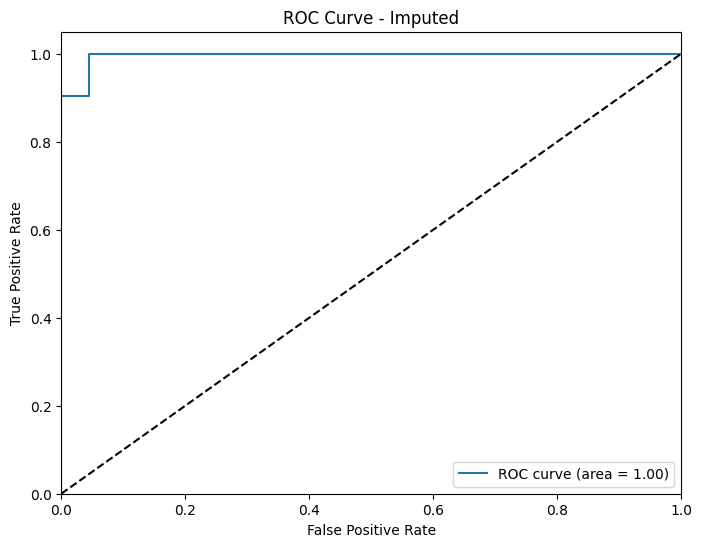

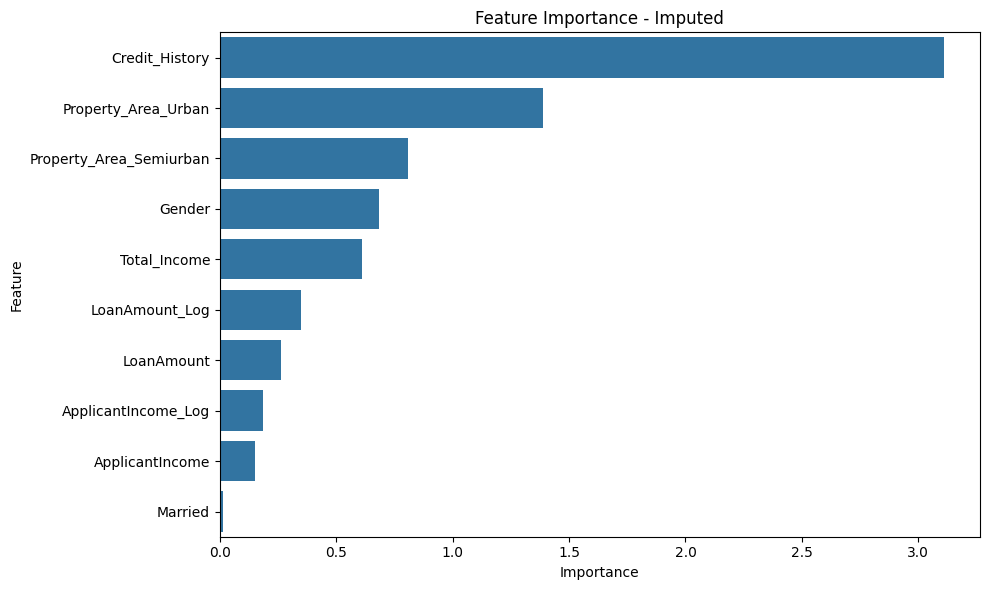


--- Evaluating Model for Removed Dataset ---
Accuracy: 0.9310
Precision: 0.9111
Recall: 1.0000
F1 Score: 0.9535
ROC-AUC Score: 0.9440
Prediction time: 0.0010 seconds
Total execution time: 0.33 seconds


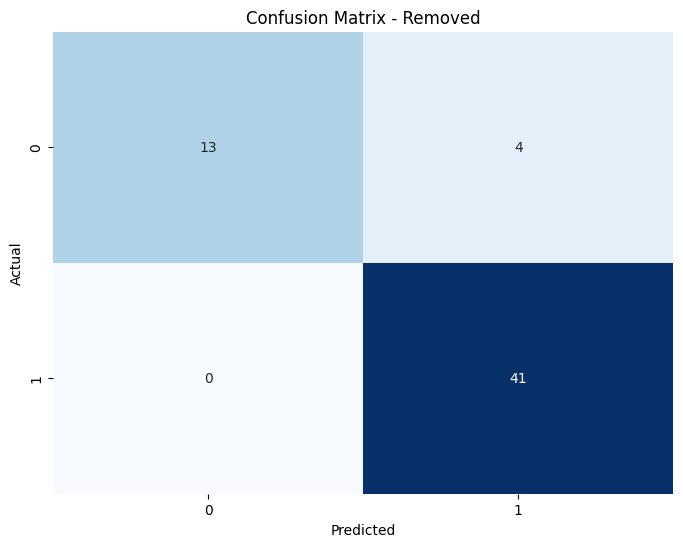

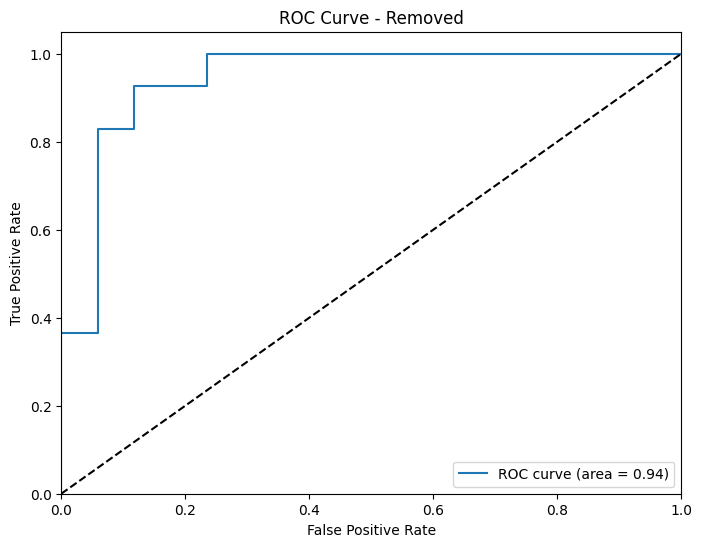

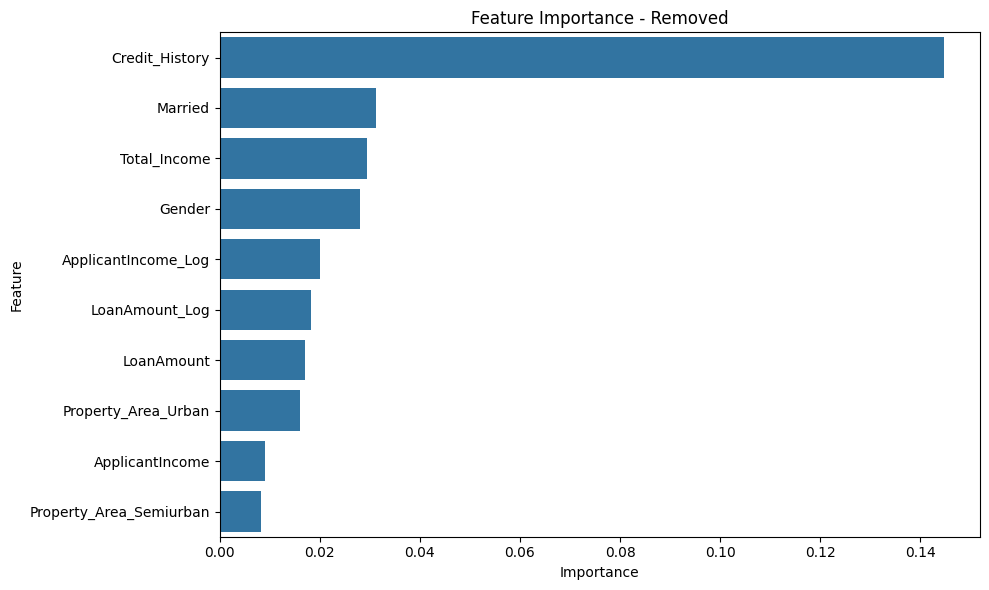

In [37]:
# Evaluate both models
metrics_imputed = evaluate_model(model_imputed, X_test_imputed, y_test_imputed, "Imputed", time_imputed, selected_features_imputed)
metrics_removed = evaluate_model(model_removed, X_test_removed, y_test_removed, "Removed", time_removed, selected_features_removed)

In [38]:
def perform_cross_validation(model, X, y, dataset_name):
    print(f"\n--- Cross-Validation for {dataset_name} Dataset ---")

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")

    # Plot cross-validation results
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, 6), cv_scores)
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title(f'Cross-Validation Results - {dataset_name}')
    plt.ylim(0, 1)
    plt.show()

    return cv_scores

def plot_learning_curve(model, X, y, dataset_name):
    print(f"\n--- Learning Curve for {dataset_name} Dataset ---")

    # Generate learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='f1')

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f"Learning Curve - {dataset_name}")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.show()


--- Cross-Validation for Imputed Dataset ---
Cross-validation scores: [0.88679245 0.92783505 0.87755102 0.85148515 0.88      ]
Mean CV Score: 0.8847
Standard Deviation: 0.0247


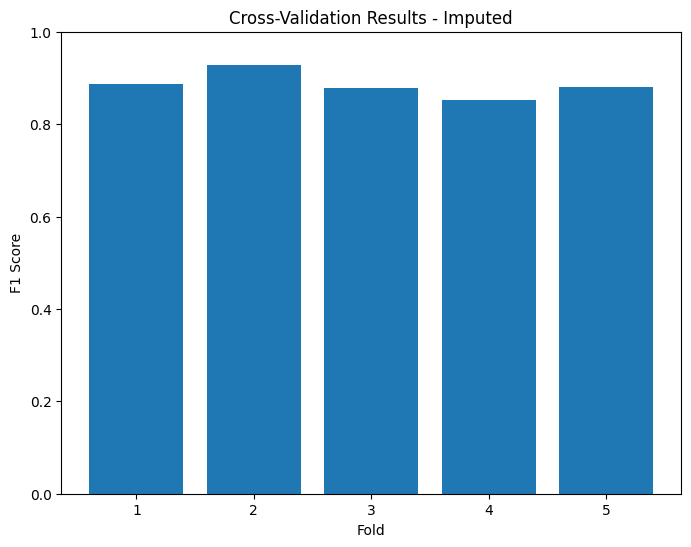


--- Learning Curve for Imputed Dataset ---


d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1276, in fit
    self.coef_, self.intercept_, self.n_it

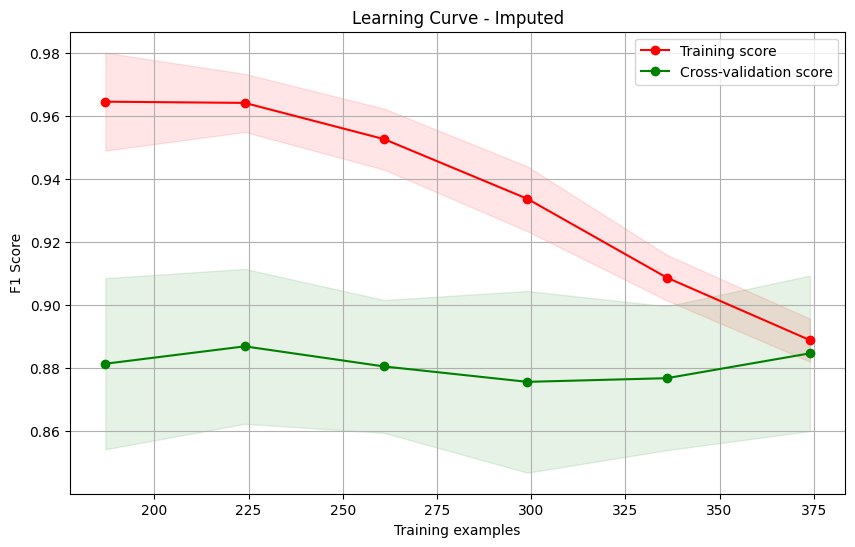


--- Cross-Validation for Removed Dataset ---
Cross-validation scores: [0.87804878 0.87804878 0.88095238 0.88888889 0.8372093 ]
Mean CV Score: 0.8726
Standard Deviation: 0.0181


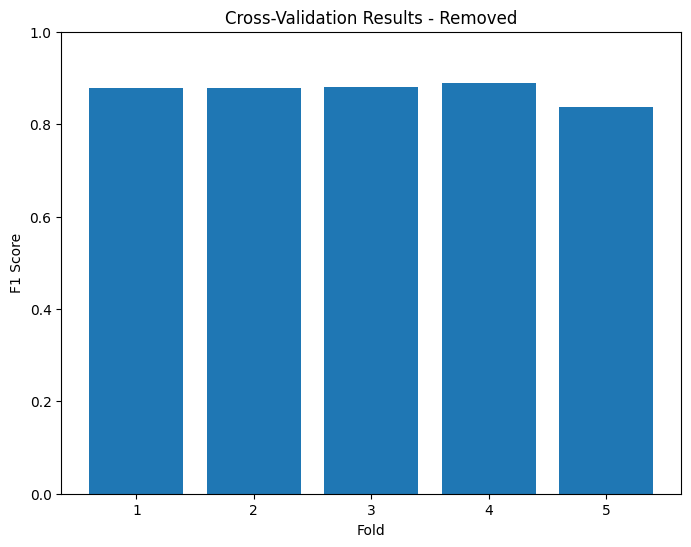


--- Learning Curve for Removed Dataset ---


d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\School\CS 434\Project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This sol

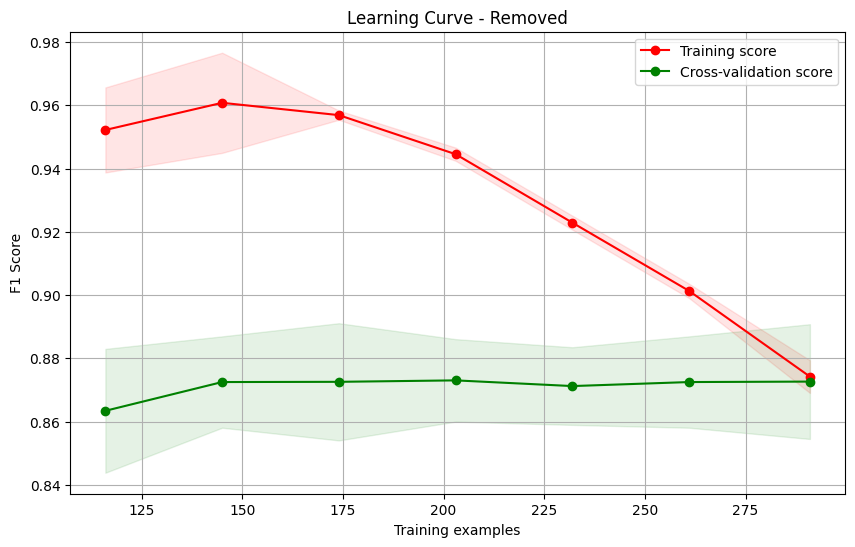

In [39]:
# Perform cross-validation and plot learning curves for both models
cv_scores_imputed = perform_cross_validation(model_imputed, X_train_imputed, y_train_imputed, "Imputed")
plot_learning_curve(model_imputed, X_train_imputed, y_train_imputed, "Imputed")

cv_scores_removed = perform_cross_validation(model_removed, X_train_removed, y_train_removed, "Removed")
plot_learning_curve(model_removed, X_train_removed, y_train_removed, "Removed")


In [40]:
def compare_models(metrics_imputed, metrics_removed, cv_scores_imputed, cv_scores_removed):
    print("\n--- Model Comparison ---")

    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 
                  'CV Mean F1', 'CV Std Dev', 'Training Time (s)', 'Prediction Time (s)'],
        'Imputed Dataset': [
            metrics_imputed['accuracy'],
            metrics_imputed['precision'],
            metrics_imputed['recall'],
            metrics_imputed['f1'],
            metrics_imputed['roc_auc'],
            cv_scores_imputed.mean(),
            cv_scores_imputed.std(),
            metrics_imputed['training_time'],
            metrics_imputed['prediction_time']
        ],
        'Removed Dataset': [
            metrics_removed['accuracy'],
            metrics_removed['precision'],
            metrics_removed['recall'],
            metrics_removed['f1'],
            metrics_removed['roc_auc'],
            cv_scores_removed.mean(),
            cv_scores_removed.std(),
            metrics_removed['training_time'],
            metrics_removed['prediction_time']
        ]
    })

    # Format numeric columns
    for col in ['Imputed Dataset', 'Removed Dataset']:
        comparison[col] = comparison[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)

    print(comparison)

    # Plot comparison of key metrics
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
    comparison_plot = comparison[comparison['Metric'].isin(metrics_to_plot)].copy()

    comparison_plot['Imputed Dataset'] = comparison_plot['Imputed Dataset'].astype(float)
    comparison_plot['Removed Dataset'] = comparison_plot['Removed Dataset'].astype(float)

    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    plt.bar(x - width/2, comparison_plot['Imputed Dataset'], width, label='Imputed Dataset')
    plt.bar(x + width/2, comparison_plot['Removed Dataset'], width, label='Removed Dataset')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return comparison


--- Model Comparison ---
                Metric Imputed Dataset Removed Dataset
0             Accuracy          0.9459          0.9310
1            Precision          0.9800          0.9111
2               Recall          0.9423          1.0000
3             F1 Score          0.9608          0.9535
4              ROC-AUC          0.9956          0.9440
5           CV Mean F1          0.8847          0.8726
6           CV Std Dev          0.0247          0.0181
7    Training Time (s)          2.5940          0.3252
8  Prediction Time (s)          0.0000          0.0010


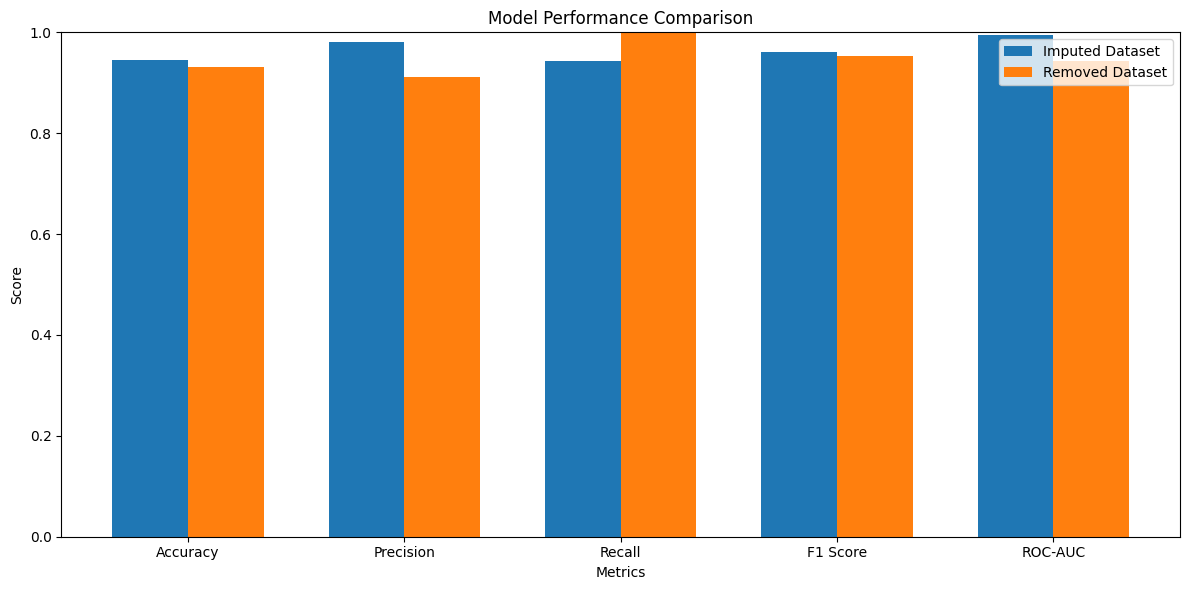

In [41]:
# Compare the models
comparison = compare_models(metrics_imputed, metrics_removed, cv_scores_imputed, cv_scores_removed)

In [42]:
def generate_summary(comparison):
    print("\n--- Final Summary and Recommendations ---")

    # Convert string values back to float for comparison
    imputed_f1 = float(comparison.loc[comparison['Metric'] == 'F1 Score', 'Imputed Dataset'].values[0])
    removed_f1 = float(comparison.loc[comparison['Metric'] == 'F1 Score', 'Removed Dataset'].values[0])

    better_model = "Imputed Dataset" if imputed_f1 > removed_f1 else "Removed Dataset"

    print(f"Based on F1 Score, the {better_model} model performs better.")

    # Analyze strengths and weaknesses
    print("\nStrengths and Weaknesses:")

    # Imputed dataset analysis
    imputed_metrics = comparison[comparison['Metric'].isin(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])]
    imputed_values = imputed_metrics['Imputed Dataset'].astype(float)
    imputed_best = imputed_metrics['Metric'][imputed_values.argmax()]
    imputed_worst = imputed_metrics['Metric'][imputed_values.argmin()]

    print(f"Imputed Dataset - Strongest metric: {imputed_best}, Weakest metric: {imputed_worst}")

    # Removed dataset analysis
    removed_values = imputed_metrics['Removed Dataset'].astype(float)
    removed_best = imputed_metrics['Metric'][removed_values.argmax()]
    removed_worst = imputed_metrics['Metric'][removed_values.argmin()]

    print(f"Removed Dataset - Strongest metric: {removed_best}, Weakest metric: {removed_worst}")

    # Recommendations
    print("\nRecommendations:")

    if better_model == "Imputed Dataset":
        print("1. Use the imputed dataset model for production as it performs better overall.")
        print("2. The imputation strategy effectively handles missing values without losing data points.")
    else:
        print("1. Use the removed dataset model for production as it performs better overall.")
        print("2. Removing rows with missing values leads to a more reliable model despite the reduced dataset size.")

    # Common recommendations
    print("3. Consider collecting more data to improve model robustness.")
    print("4. Focus on improving the model's performance on its weakest metric.")
    print("5. Explore more advanced feature engineering techniques to capture complex relationships.")
    print("6. Consider ensemble methods to potentially improve overall performance.")

In [ ]:
# Generate final summary
generate_summary(comparison)


--- Final Summary and Recommendations ---
Based on F1 Score, the Imputed Dataset model performs better.

Strengths and Weaknesses:
Imputed Dataset - Strongest metric: ROC-AUC, Weakest metric: Recall
Removed Dataset - Strongest metric: Recall, Weakest metric: Precision

Recommendations:
1. Use the imputed dataset model for production as it performs better overall.
2. The imputation strategy effectively handles missing values without losing data points.
3. Consider collecting more data to improve model robustness.
4. Focus on improving the model's performance on its weakest metric.
5. Explore more advanced feature engineering techniques to capture complex relationships.
6. Consider ensemble methods to potentially improve overall performance.
